In [5]:
"""
ENGD Optimization.
One dimensional heat equation example. Solution given by

u(t,x) = exp(pi**2 * t * 0.25) * sin(pi * x).

"""
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.flatten_util import ravel_pytree

from ngrad.models import mlp, init_params
from ngrad.domains import Square, SquareBoundary
from ngrad.integrators import DeterministicIntegrator
from ngrad.inner import model_identity, model_del_i_factory
from ngrad.gram import gram_factory, nat_grad_factory
from ngrad.utility import grid_line_search_factory, del_i

jax.config.update("jax_enable_x64", True)

# random seed
seed = 0

# domains
interior = Square(1.)
initial = SquareBoundary(1., side_number=3)
rboundary = SquareBoundary(1., side_number=0)
lboundary = SquareBoundary(1., side_number=2)

# integrators
interior_integrator = DeterministicIntegrator(interior, 30)
initial_integrator = DeterministicIntegrator(initial, 30)
rboundary_integrator = DeterministicIntegrator(rboundary, 30)
lboundary_integrator = DeterministicIntegrator(lboundary, 30)
eval_integrator = DeterministicIntegrator(interior, 300)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 64, 1]
params = init_params(layer_sizes, random.PRNGKey(seed))
model = mlp(activation)
v_model = vmap(model, (None, 0))

# initial condition
def u_0(tx):
    x = tx[1]
    return jnp.sin(jnp.pi * x)
v_u_0 = vmap(u_0, (0))

# solution
def u_star(tx):
    t = tx[0]
    x = tx[1]
    return jnp.exp(-jnp.pi**2 * t * 0.25) * jnp.sin(jnp.pi * x)

# defining heat eq inner product
model_del_0 = model_del_i_factory(argnum=0)
model_del_1 = model_del_i_factory(argnum=1)

def model_heat_eq_factory(diffusivity=1.):
    def model_heat_eq(u_theta, g):
        dg_1 = model_del_0(u_theta, g)
        ddg_2 = model_del_1(u_theta, (model_del_1(u_theta, g)))

        def return_heat_eq(x):
            flat_dg_1, unravel = ravel_pytree(dg_1(x))
            flat_ddg_2, unravel = ravel_pytree(ddg_2(x))
            return unravel(flat_dg_1 - diffusivity * flat_ddg_2)
        
        return return_heat_eq

    return model_heat_eq

# assembling gramians
gram_l_boundary = gram_factory(
    model = model,
    trafo = model_identity,
    integrator = lboundary_integrator
)

gram_r_boundary = gram_factory(
    model = model,
    trafo = model_identity,
    integrator = rboundary_integrator
)

gram_initial = gram_factory(
    model = model,
    trafo = model_identity,
    integrator = initial_integrator
)

model_heat_eq = model_heat_eq_factory(0.25)
gram_heat = gram_factory(
    model = model,
    trafo = model_heat_eq,
    integrator = interior_integrator
)

# the full inner product
@jit
def gram(params):
    return (
    gram_l_boundary(params) + 
    gram_r_boundary(params) + 
    gram_initial(params) + 
    gram_heat(params)
    )

# maps: params, tangent_params ---> tangent_params
nat_grad = nat_grad_factory(gram)

# differential operators
dt = lambda g: del_i(g, 0)
ddx = lambda g: del_i(del_i(g, 1), 1)
def heat_operator(u):
    return lambda tx: (dt(u)(tx) - 0.25 * ddx(u)(tx))**2

# loss terms
@jit
def loss_interior(params):
    heat_model = heat_operator(lambda tx: model(params, tx))
    return interior_integrator(vmap(heat_model, (0)))
@jit
def loss_boundary(params):
    return (
        lboundary_integrator(lambda tx: v_model(params, tx)**2) 
            + rboundary_integrator(lambda tx: v_model(params, tx)**2))
@jit
def loss_initial(params):
    return initial_integrator(
        lambda tx: (v_u_0(tx) - v_model(params, tx))**2)
@jit
def loss(params):
    return loss_interior(params) + loss_boundary(params) + loss_initial(params)

# set up grid line search
grid = jnp.linspace(0, 30, 31)
steps = 0.5**grid
ls_update = grid_line_search_factory(loss, steps)    

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(
        lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5
        )

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5    

# training loop
iterations = 1000
save_freq = 10

for iteration in range(iterations + 1):
    interior_grads = grad(loss_interior)(params)
    interior_nat_grads = nat_grad(params, interior_grads)
    
    boundary_grads = grad(loss_boundary)(params)
    boundary_nat_grads = nat_grad(params, boundary_grads)
    
    initial_grads = grad(loss_initial)(params)
    initial_nat_grads = nat_grad(params, initial_grads)
    
    updates = jax.tree_util.tree_map(lambda x, y, z: (x + y + z) / 3, interior_nat_grads, boundary_nat_grads, initial_nat_grads)
    
    params, actual_step = ls_update(params, updates)
    
    if iteration % save_freq == 0:
        # errors
        l2_error = l2_norm(v_error, eval_integrator)
        h1_error = l2_error + l2_norm(v_error_abs_grad, eval_integrator)
    
        print(
            f'ENGD Iteration: {iteration}'
            f'\n  with loss: {loss_interior(params)} + {loss_boundary(params)} + {loss_initial(params)} = {loss(params)}'
            f'\n  with error L2: {l2_error} and error H1: {h1_error}'
            f'\n  with step: {actual_step}'
        )


ENGD Iteration: 0
  with loss: 0.002921432961750073 + 0.030050266893142816 + 0.340004067047093 = 0.3729757669019859
  with error L2: 0.23494802145874732 and error H1: 1.475836155549851
  with step: 5.960464477539063e-08
ENGD Iteration: 10
  with loss: 0.0029214358914070935 + 0.030050148653274062 + 0.34000399629192857 = 0.3729755808366097
  with error L2: 0.23494803976360074 and error H1: 1.4758356645035875
  with step: 5.960464477539063e-08
ENGD Iteration: 20
  with loss: 0.0029214375259402335 + 0.030050035183219435 + 0.3400039279864807 = 0.3729754006956404
  with error L2: 0.23494805892099527 and error H1: 1.4758351817439188
  with step: 5.960464477539063e-08
ENGD Iteration: 30
  with loss: 0.002921437734646754 + 0.030049925858455347 + 0.34000386461021803 = 0.37297522820332013
  with error L2: 0.23494808015460256 and error H1: 1.475834709361497
  with step: 5.960464477539063e-08
ENGD Iteration: 40
  with loss: 0.002921436395118159 + 0.030049820259544224 + 0.3400038081727522 = 0.372975

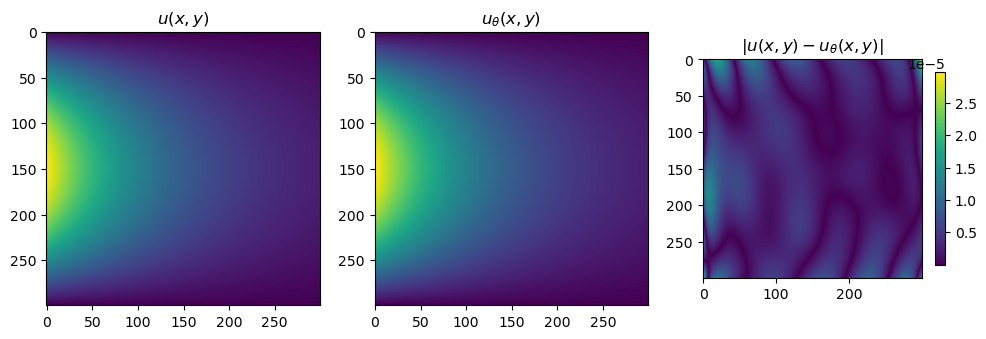

In [10]:
from util import save


n = 300
save("heat", n, u_star, v_model, params)